## **Final Group Assignment Text Retreival and Mining** 
## **Group 4**

**Group Members:**


Ivona Birlad - (14020939)


Gabriel Wagner - (13488449)


Julia Zeuzem – (12880035)


Till Konczak - (12180394)


Valeria Lee – (12596957)

In [ ]:
!wget https://amsuni-my.sharepoint.com/:u:/g/personal/j_rossi_uva_nl/EXxjDMweOshJi9wpKeIwerkBQKeLcYATDh9zfY2H1cr-fw?download=1 -O all-the-news.zip

--2022-01-29 21:00:14--  https://amsuni-my.sharepoint.com/:u:/g/personal/j_rossi_uva_nl/EXxjDMweOshJi9wpKeIwerkBQKeLcYATDh9zfY2H1cr-fw?download=1
Resolving amsuni-my.sharepoint.com (amsuni-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to amsuni-my.sharepoint.com (amsuni-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/j_rossi_uva_nl/Documents/all-the-news.zip [following]
--2022-01-29 21:00:16--  https://amsuni-my.sharepoint.com/personal/j_rossi_uva_nl/Documents/all-the-news.zip
Reusing existing connection to amsuni-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 265107114 (253M) [application/x-zip-compressed]
Saving to: ‘all-the-news.zip’

all-the-news.zip     28%[====>               ]  71.64M  18.1MB/s    eta 20s    ^C


In [ ]:
!unzip all-the-news.zip

Archive:  all-the-news.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of all-the-news.zip or
        all-the-news.zip.zip, and cannot find all-the-news.zip.ZIP, period.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#Concatenating the three data files into one dataframe
df = pd.concat(map(pd.read_csv, ['articles1.csv', 'articles2.csv','articles3.csv']))

In [ ]:
#Renaming the index column 
df = df.rename(columns = {"Unnamed: 0":"index"})
df = df.set_index("index")

In [ ]:
print(df.shape)
df.head()

(142570, 9)


,id,title,publication,author,date,year,month,url,content
index,,,,,,,,,
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


#### **1 and 2: Describe a publication by frequency or TD-IDF**
 


---


We built two helper funtions to help solve the first two assignment tasks. `get_common_words` and `plot_top` help create the bag of words with either `CountVectorizer` or `TfidfVectorizer` and plot the top 10 most frequest unigrams and bigrams. 


As requested under 1b, we the selected parameters for the `CountVectorizer` in order to only include words made entirely of at least 3 letters in the bow, transform all texts to lowercase and remove English stopwords. We also decided to restict the words seleted to only those that appeared in more than 5 documents, less than 80% of the corpus in order to obtain more relevant unigrams and bigrams.   

Very silimarly, for the `TfidfVectoreizer` we slected only lowercase words made entirely of letters with at least 2 letters and removed English stopwords. We also made sure to lemmatize the text before fitting and transforming it with the vectorizer. This ensured words would be reduced to their respective lemma. 

In [ ]:
#helper functions
def get_common_words(newspaper, n_gram_length, vectorizer):
    '''
    takes newspaper name as input, an integer n_gram_length and a string vectorizer as input
    returns 10 most common n_grams used by newspaper
    '''
    
    np = df[df["publication"] == newspaper]
    text = np["content"]
    
    if vectorizer == "count":
      vect = CountVectorizer(
          lowercase = True,    
          stop_words= "english",
          ngram_range = (n_gram_length, n_gram_length),
          token_pattern = r"[a-z]{3,}",
          min_df=5,
          max_df=0.8,
          )

    elif vectorizer == "tf":
      lemmatizer=WordNetLemmatizer()
      text = [' '.join([lemmatizer.lemmatize(word) for word in t.split(' ')]) for t in text]

      vect = TfidfVectorizer(
          lowercase = True,
          stop_words= "english",
          token_pattern=r'[a-z]{2,}',
          max_features=50000,
          min_df=5,
          max_df=0.8,
          ngram_range=(n_gram_length, n_gram_length)
          )

    else:
      raise ValueError("Invalid vectorizer. Please pass vectorizer = tf or count")

    bow = vect.fit_transform(text)
    
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    top_10 = words_freq[:10]
    
    return top_10

#############################################################################

def plot_top(ngram,title, x, y):
    '''
    creates a simple barplot to display words and their frequency
    '''
    ngram = dict(ngram)
    plt.barh(range(len(ngram)), ngram.values(), color = "#BEB511")
    plt.yticks(range(len(ngram)), ngram.keys())
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.gca().invert_yaxis()   

In [ ]:
unigrams = get_common_words("Breitbart", 1, "count")
bigrams = get_common_words("Breitbart", 2, "count")
print(unigrams)
print(bigrams)

[('trump', 66359), ('said', 51074), ('people', 31153), ('clinton', 30409), ('president', 26352), ('news', 23367), ('twitter', 22539), ('new', 21693), ('breitbart', 20995), ('state', 18232)]
[('donald trump', 16448), ('breitbart news', 10149), ('hillary clinton', 9789), ('united states', 7866), ('pic twitter', 6784), ('new york', 6589), ('white house', 4987), ('breitbart texas', 3518), ('follow twitter', 3515), ('fox news', 2846)]


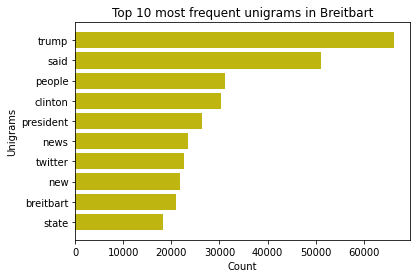

In [ ]:
plot_top(unigrams, "Top 10 most frequent unigrams in Breitbart", "Count", "Unigrams")

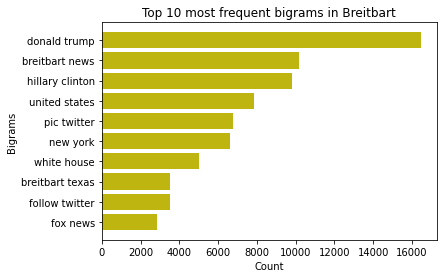

In [ ]:
plot_top(bigrams, "Top 10 most frequent bigrams in Breitbart", "Count", "Bigrams") 

From the analysis of the top unigrams and bigrams we can see that U.S. political topics seemed to be very present in Breitbart articles. Particularly it seems that Donald Trump's politics and associated political themes such as "(Hillary) Clinton" and "Twitter (Trump was an avid twitter user)" were very dominant topics for Breitbart.

This makes sense since the articles used for this analysis cover at least three years of Trump's presidency (2014-2017) and Breitbart as a publication rose in readership and importance especially in those years through gaining attention from Trump supporters.

One other interesting thing is Breitbart mentioned their own name so much. This could be because Breitbart is known for promoting themselves as 'alternative media' and therefore run a lot of stories about how they are different from the 'established media'.

In [ ]:
unigrams = get_common_words("Atlantic", 1, "tf")
bigrams = get_common_words("Atlantic", 2, "tf")
print(unigrams)
print(bigrams)

[('trump', 425.9464848014368), ('said', 187.16878953940383), ('people', 179.98878029574414), ('like', 149.73147352091954), ('clinton', 146.09010404698472), ('president', 144.01097153386448), ('new', 137.73835676365482), ('year', 125.73227691061777), ('state', 119.3376611042592), ('time', 116.26085667077514)]
[('donald trump', 125.56428812723321), ('united states', 118.74572448873562), ('new york', 111.38998466756485), ('receive update', 95.86133426403217), ('want receive', 95.85599295507886), ('update partner', 95.84863320227224), ('partner sponsors', 95.84863320227224), ('hillary clinton', 82.52875197037531), ('white house', 77.15320099088181), ('display ads', 68.30551131492759)]


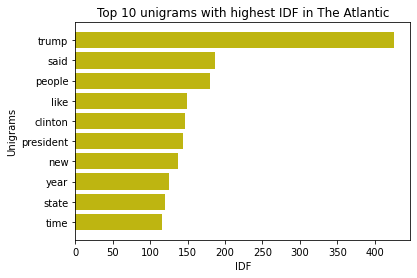

In [ ]:
plot_top(unigrams, "Top 10 unigrams with highest IDF in The Atlantic", "IDF", "Unigrams")

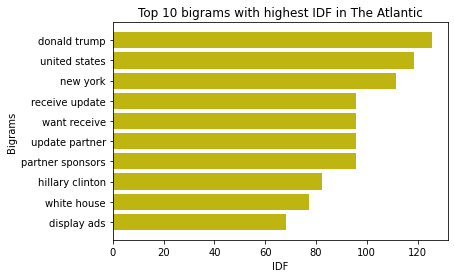

In [ ]:
plot_top(bigrams, "Top 10 bigrams with highest IDF in The Atlantic", "IDF", "Bigrams") 

As with the unigrams and bigrams of Breitbart, the TD-IDF unigrams and bigrams in The Atlantic also seem to correspond most to the topic of U.S. politics. 

In this case we applied TD-IDF so that we can infer that the selected uni/bigrams were not just frequent, but also particularly important for this publication. We can see that Donald Trump and Hillary Clinton were frequently talked about. As with Breitbart this makes sense, as The Atlantic often discusses politics and the text data we used was taken from an era in which Donald Trump and his associated politics were very dominant in the political discourse. 

Interesting, however, is that also 'New York' was particularly important for The Atlantic. This makes sense as The Atlantic focuses more on East Coast matters, compared to other US publications. 

#### **3. Topic Modeling**


In [ ]:
#Selecting all articles from New York Times
NYT = df[df["publication"] == "New York Times"]
NYTtext = NYT["content"]

When constructing the LDA model we chose to use the sklearn LatentDirichletAllocation and evaluate it based on its perplexity. 


We also chose to also lemmatize the words because we observed words with the same lemma popping up in the wordcloud, making the top 10 selection less relevant. Furthermore we extended the list of English stopwords to be removed to a few more that we observed appering in the wordcloud. 

In [ ]:
#Building a vectorizer and fitting the text of NYT publications
stop = stopwords.words('english') + ["said", "like", "mrs"]
lemmatizer = WordNetLemmatizer()
NYTtext = [' '.join([lemmatizer.lemmatize(word) for word in t.split(' ')]) for t in NYTtext]

count = CountVectorizer(
    lowercase = True,
    stop_words = stop,
    token_pattern = r"[a-z]{3,}",
    ngram_range = (1,1),
    min_df=5,
    max_df=0.85,
    )

bow = count.fit_transform(NYTtext)

#Building a topic model with 20 topics and fitting it on the bow
K = 20

lda = LatentDirichletAllocation(
    n_components=K,
    max_iter=10, 
    random_state=42
    )

lda.fit(bow)

LatentDirichletAllocation(n_components=20, random_state=42)

In [ ]:
print("Perplexity: ", lda.perplexity(bow))

Perplexity:  4323.088583380697


#### WordClout for each topic 

*Wordcloud code reference: LDA Notebook Week 2*



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


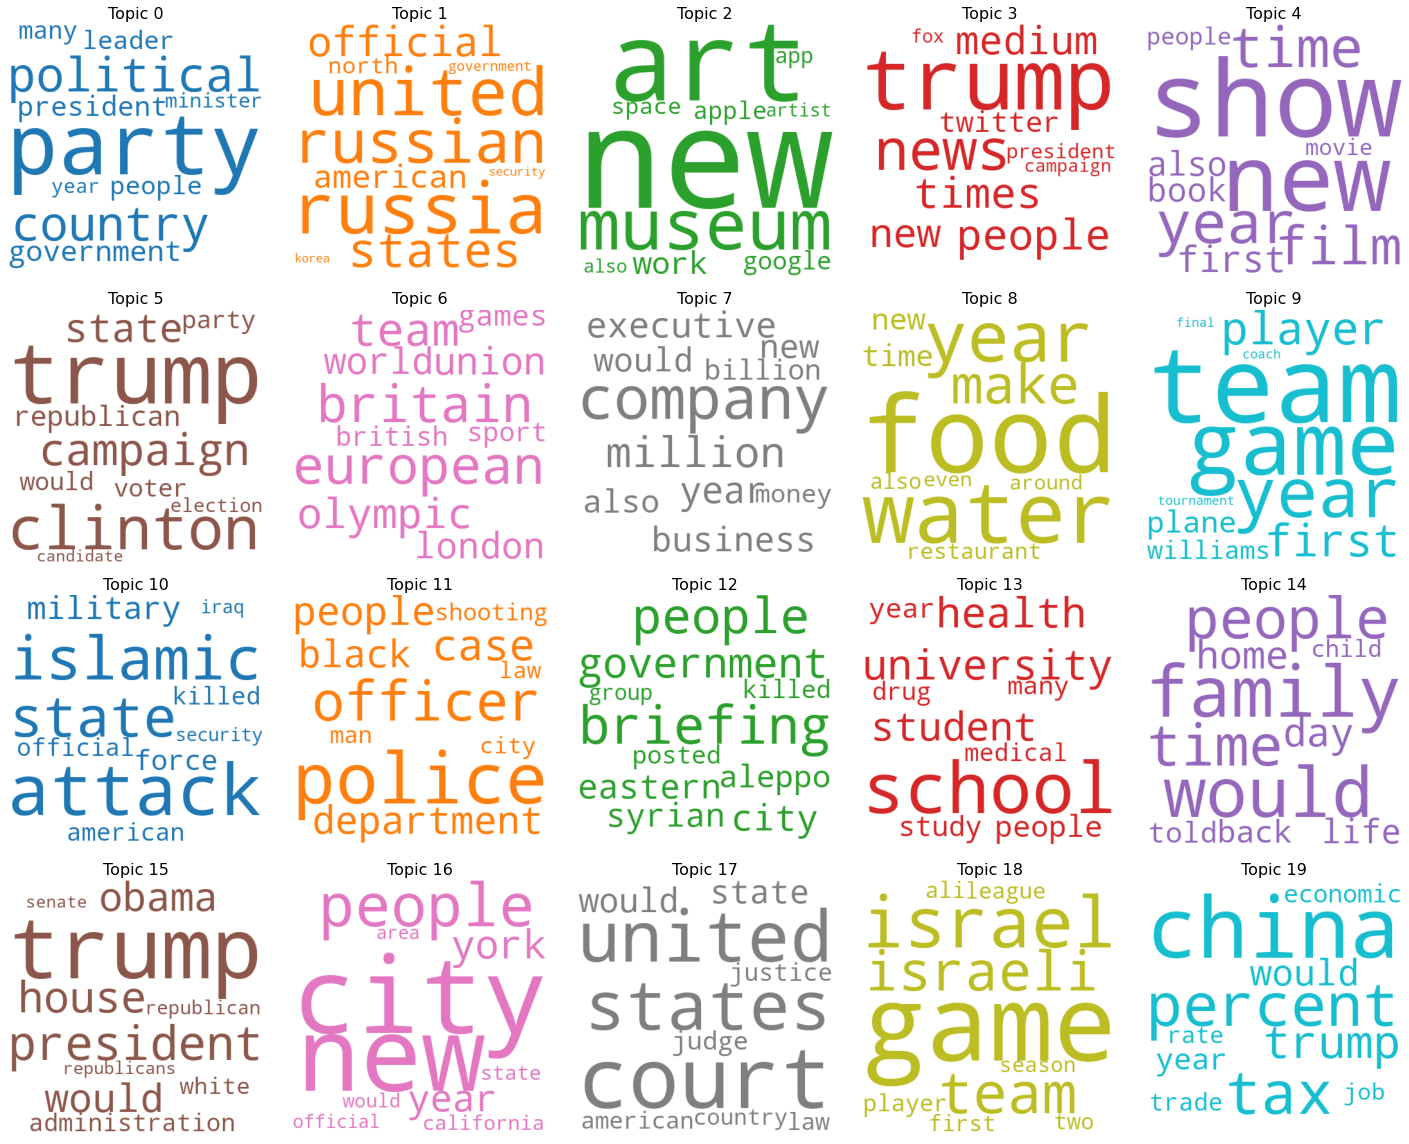

In [ ]:
col = 5
row = math.ceil(K / col)

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 
cols = cols * math.ceil(K / len(cols))


cloud = WordCloud(background_color='white',
                  width=400,
                  height=400,
                  max_words=10,
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.components_
feature_names = count.get_feature_names()
n_top_words = 10

fig, axes = plt.subplots(ncols=col, nrows=row, 
                         figsize=(4*col, 4*row), 
                         sharex=True, sharey=True)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    topic_words = {feature_names[i]: topic[i] for i in top_features_ind}

    cloud.generate_from_frequencies(topic_words, max_font_size=250)
    ax.imshow(cloud)
    ax.set_title(f'Topic {i}', fontdict=dict(size=16))
    ax.axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

**Explanation & Interpretation:**

All articles from the New York Times were selected and terms that occured in less than 5 articles or more than 85% of document frequency were filtered out from the corpus. 

Using LDA, a topic model was built with 20 topics, which have been displayed using wordclouds of the 10 most important words per topic.  

From our own subjective interpretation of the wordclouds, we have determined the following topics: tech companies, China, sports game, U.S. presidential elections, Western politics, women, French economy, New York life and education, U.S. politics, Islam, police violence against POC, tragic plane accident, law, war in Middle East, Olympic games, and world economy.

We can still observe derivations of the same word appearing in the distibution of the same topic (eg. russia-russian). This is because the lemmatizer only reduces plurals and certain conjugations to the same lemma. In this case, maybe a stemmer would have been more fit. 

However, one question comes to mind: Is 20 topics the optimal number of topic for this LDA model? The wordcloud seems to have clustered certain words together without an obious connection (example topic 11). We would like to grid search for the optimal number of topics to be included.  

In [ ]:
search_params = {'n_components': [10, 15, 20, 25, 30]}
ldaGS = LatentDirichletAllocation()
model = GridSearchCV(ldaGS, param_grid=search_params)
model.fit(bow)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'n_components': [10, 15, 20, 25, 30]})

In [ ]:
best_lda_model = model.best_estimator_
print("Best Params: ", model.best_params_)
print("Model Perplexity: ", best_lda_model.perplexity(bow))

Best Model's Params:  {'n_components': 10}
Model Perplexity:  4601.338305459462


Indeed it does appear that 10 topics would be a better choice for the number of components included in the LDA model. This may explain why some of the words we observed in the topic wordclouds above did not appear to be very relevant.

#### **4. Predict a publication**

First, all articles from the New York Post and Breitbart were selected and this corpus was split into train and test set. 

In [ ]:
#Selecting articles from both the New York Post and Breitbart
dfr = df[(df["publication"] == "New York Post") | (df["publication"] == "Breitbart")]

In [ ]:
#Separating the label and splitting the dataframe into train and test sets
X = dfr["content"]
y = dfr["publication"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### Fitting the LDA vectors to the training and test sets





A count vectorizer was created and programmed to consider words in lowercase, remove English stopwords, include only unigrams and filter terms by document frequency so that terms that occured in less than 5 articles or more than 85% of document frequency were filtered out from the corpus. LDA model with 20 topics was fit to the train and test sets. 


In [ ]:
X_train_bow = count.fit_transform(X_train)
X_test_bow = count.transform(X_test)

lda.fit_transform(X_train_bow)
lda.fit(X_test_bow)

LatentDirichletAllocation(n_components=20, random_state=42)

#### Building the Logistic Regression and Random Forest Classifiers and fitting them to the LDA bow

Two classifiers were built, Logistic Regression and Random Forest, showing that the logistic regression performed better on predicting the classes ( Breitband (F1-score=0.93) and New York Post (F1-score=0.9) ) than the random forest (F1-scores of 0.91 & 0.86 respectively).

In [ ]:
lr = LogisticRegression(max_iter = 1e4, random_state = 42)
lr = lr.fit(X_train_bow, y_train)
rf = RandomForestClassifier(random_state = 42)
rf = rf.fit(X_train_bow, y_train)

In [ ]:
#Computing evaluation metrics for Logistic Regression Classifier
y_pred_lr = lr.predict(X_test_bow)
print(classification_report(y_true = y_test, y_pred = y_pred_lr))

               precision    recall  f1-score   support

    Breitbart       0.93      0.93      0.93      4817
New York Post       0.90      0.91      0.90      3438

     accuracy                           0.92      8255
    macro avg       0.92      0.92      0.92      8255
 weighted avg       0.92      0.92      0.92      8255



In [ ]:
#Computing evaluation metrics for Random Forest Classifier
y_pred_rf = rf.predict(X_test_bow)
print(classification_report(y_true = y_test, y_pred = y_pred_rf))

               precision    recall  f1-score   support

    Breitbart       0.87      0.95      0.91      4817
New York Post       0.92      0.81      0.86      3438

     accuracy                           0.89      8255
    macro avg       0.90      0.88      0.89      8255
 weighted avg       0.89      0.89      0.89      8255



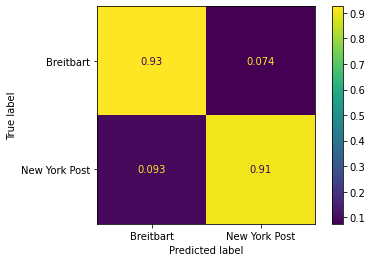

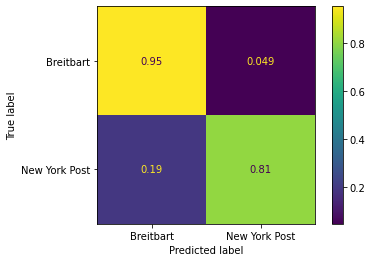

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr, X = X_test_bow, y=y_test, normalize="true")
ConfusionMatrixDisplay.from_estimator(rf, X = X_test_bow, y=y_test, normalize="true")

#### Bulding the TfidfVectorizer and fitting the vectors to the training and test sets


A TF-IDF vectorizer was created with the same parameters as the CountVectorrizer used for the LDA model above. Again, train and test bag of words where generated using the vectorizer and a logistic regression and random forest were created. 


In [ ]:
tfidf = TfidfVectorizer(
    lowercase = True,
    stop_words= "english",
    token_pattern=r'[a-z]{3,}',
    max_features=50000,
    min_df=5,
    max_df=0.85,
    ngram_range=(1, 1)
    )

X_train_bow_tf = tfidf.fit_transform(X_train)
X_test_bow_tf = tfidf.transform(X_test)

#### Building the Logistic Regression and Random Forest Classifiers and fitting them to the TF-IDF bow

In [ ]:
lr = LogisticRegression(max_iter = 1e4, random_state=42)
lr = lr.fit(X_train_bow_tf, y_train)
rf = RandomForestClassifier(warm_start = True, random_state=42)
rf = rf.fit(X_train_bow_tf, y_train)

In [ ]:
#Computing evaluation metrics for Logistic Regression Classifier
y_pred_lr = lr.predict(X_test_bow_tf)
print(classification_report(y_true = y_test, y_pred = y_pred_lr))

               precision    recall  f1-score   support

    Breitbart       0.92      0.94      0.93      4817
New York Post       0.91      0.89      0.90      3438

     accuracy                           0.92      8255
    macro avg       0.92      0.91      0.91      8255
 weighted avg       0.92      0.92      0.92      8255



In [ ]:
#Computing evaluation metrics for Random Forest Classifier
y_pred_rf = rf.predict(X_test_bow_tf)
print(classification_report(y_true = y_test, y_pred = y_pred_rf))

               precision    recall  f1-score   support

    Breitbart       0.87      0.96      0.91      4817
New York Post       0.93      0.81      0.86      3438

     accuracy                           0.89      8255
    macro avg       0.90      0.88      0.89      8255
 weighted avg       0.90      0.89      0.89      8255



The logistic regression showed better results on predicting Breitband (F1-score=0.93) and New York Post (F1-score=0.9) labels than the random forest (F1-scores of 0.91 & 0.86 respectively).

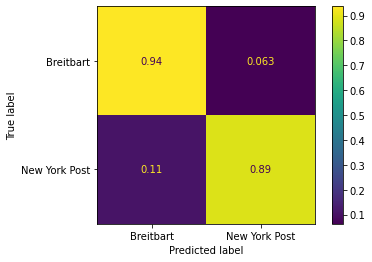

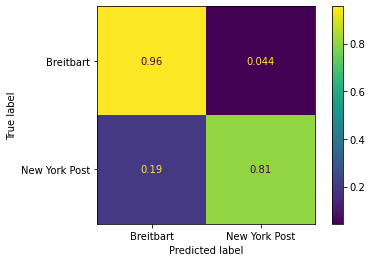

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr, X = X_test_bow_tf, y=y_test, normalize="true")
ConfusionMatrixDisplay.from_estimator(rf, X = X_test_bow_tf, y=y_test, normalize="true")


**Explanation & Interpretation:**


One can see, that the classifiers bulit using the LDA model and TF-IDF vectorizer do not differ in accuracy and f1-score. Thre are slight differences in precision and recall between the two, but nothing too noticeable. Thus, we may conclude that in this case, a classifier using TF-IDF vectors performed just as well as the same classifier using LDA vectors with raw counts.